In [4]:
import matplotlib.pyplot as plt
import pandas as pd
# 为什么在weather上的结果不好，实际观察来看，在绝大多数时候是好过NHITS的，但是求出来的值并不好
mix = pd.read_csv('data/192_mix_std_deco_forecasts.csv')
# nhits = pd.read_csv('data/96_nhits_forecasts.csv')
for column in mix['unique_id'].unique():

    
    plt.figure(figsize=(20,5))
    plt.title(column)
    plt.plot(mix[mix['unique_id']==column][20000:24000]['y'],label='y')
    plt.plot(mix[mix['unique_id']==column][20000:24000]['AutoMIXModel'],label='mix')
    plt.legend()


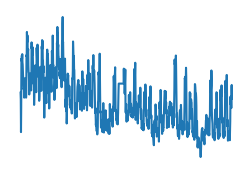

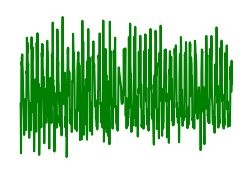

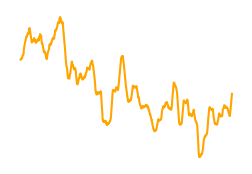

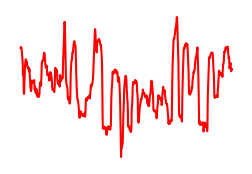

In [ ]:
### 测试两个序列模块


import torch
import torch.nn as nn

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class moving_std(nn.Module):
    """
    Moving standard deviation block for time series data
    """

    def __init__(self, kernel_size, stride):
        super(moving_std, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        # Calculate the standard deviation using a sliding window
        batch_size, seq_len, num_features = x.size()
        pad_size = min((self.kernel_size - 1) // 2, seq_len - 1)
        padded_x = torch.nn.functional.pad(x.permute(0,2,1), (pad_size, pad_size), mode='reflect').permute(0,2,1)
        std_values = []
       
        for i in range(0, seq_len, self.stride):
            window = padded_x[:, i:i+self.kernel_size, :]
            std = torch.std(window, dim=1, unbiased=False)
            std_values.append(std)
        std_values = torch.stack(std_values, dim=1)
        return std_values
    
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info    
Y_df = LongHorizon2.load(directory="./data/", group='ETTh1')
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
import torch
input_sequence = torch.tensor(Y_df["y"].values[1000:2000])

input_sequence = input_sequence.unsqueeze(0).unsqueeze(2)

mv = moving_avg(25,1)
ms = moving_std(25,1)
seq_std = ms(input_sequence)
seq_mean = mv(input_sequence)
seq_norm = (input_sequence - seq_mean)/seq_std

import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(input_sequence[0].T[0])
plt.axis('off')
plt.show()
plt.figure(figsize=(3,2))
plt.plot(seq_norm[0].T[0],color='green')
plt.axis('off')
plt.show()
plt.figure(figsize=(3,2))
plt.plot(seq_mean[0].T[0],color='orange')
plt.axis('off')
plt.show()
plt.figure(figsize=(3,2))
plt.plot(seq_std[0].T[0],color='red')
plt.axis('off')
plt.show()

# plt.plot((input_sequence[0].T[0] - seq_mean[0].T[0])/seq_std[0].T[0])

In [ ]:
from neuralforecast.core import NeuralForecast 

# nf = NeuralForecast.load('./checkpoints/best_ECL/')
# nf.models[0].hparams

Global seed set to 2023


"activation":                   gelu
"alias":                        None
"attn_dropout":                 0.0
"batch_normalization":          True
"batch_size":                   32
"decoder_layers":               1
"drop_last_loader":             False
"dropout":                      0.2
"dropout_prob_theta":           0.2
"early_stop_patience_steps":    -1
"encoder_layers":               3
"exclude_insample_y":           False
"fc_dropout":                   0.2
"futr_exog_list":               None
"h":                            96
"head_dropout":                 0.0
"hidden_size":                  128
"hist_exog_list":               None
"inference_windows_batch_size": 1024
"input_size":                   512
"interpolation_mode":           linear
"is_pretrain":                  False
"learn_pos_embed":              True
"learning_rate":                0.001
"linear_hidden_size":           256
"loss":                         MAE()
"max_steps":                    300
"mlp_activation

In [23]:
### 这个文件和automixmodel是一样的，只是为了测试交叉验证的结果和
# predictisample的结果是否一致，有可能是predictisample的结果没有经过标准化。

# 经过实验证明predictinsample的结果确实没有标准化

# 监控模型训练过程中的loss， lr， parameters and gradients，先用tensorboard，后面再用wandb


import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import pandas as pd

from neuralforecast.core import NeuralForecast
from neuralforecast.models.mixmodel_rescale_deco import MIXModel

from neuralforecast.losses.pytorch import MAE, MSE
from neuralforecast.losses.numpy import mae, mse

# from datasetsforecast.long_horizon import LongHorizon, LongHorizonInfo
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


input_size = 512
horizon = 96
dataset = "ECL"
epochs = 300

Y_df = LongHorizon2.load(directory="./data/", group=dataset)
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
n_time = LongHorizon2Info[dataset].n_time
freq = LongHorizon2Info[dataset].freq
val_size = LongHorizon2Info[dataset].val_size
test_size = LongHorizon2Info[dataset].test_size
# test_size = int(n_time/10)   # 10% 的数据作为测试集

Y_df.drop(columns=["index"], inplace=True)

mixmodel = MIXModel(
        h = horizon,
        input_size = input_size,
        decomp_kernel_size=25,
        transformer_input_size = 192,

        n_blocks = [1, 1, 1],
        mlp_units = 3 * [[512, 512]],
        n_pool_kernel_size = [16, 8, 1],
        n_freq_downsample = [16, 8, 1],
        pooling_mode = "MaxPool1d",
        interpolation_mode = "linear",
        dropout_prob_theta=0.2,
        mlp_activation = "ReLU",

        encoder_layers = 3,
        n_heads = 16,
        hidden_size = 128,
        linear_hidden_size = 256,
        dropout = 0.2,
        fc_dropout = 0.2,
        head_dropout = 0.0,
        attn_dropout = 0.0,
        patch_len = 16,
        stride = 8,
        revin = True,    
        revin_affine = False,
        revin_subtract_last = True,
        activation = "gelu",
        res_attention = True,  
        batch_normalization = True, # prenorm
        learn_pos_embed = True,
        loss=MAE(),
        valid_loss=MAE(),
        max_steps = epochs,
        learning_rate = 1e-4,
        num_lr_decays = -1,
        early_stop_patience_steps = 3,
        val_check_steps = 20,
        batch_size = 32,
        valid_batch_size = None,
        windows_batch_size = 1024, 
        inference_windows_batch_size = 1024,
        step_size = 2,
        scaler_type = "identity",
        random_seed = 2023,
        num_workers_loader = 0, 
        stat_exog_list=None,
        hist_exog_list=None,
        futr_exog_list=None,
        exclude_insample_y=False,
        drop_last_loader=False,
)

nf = NeuralForecast(models=[mixmodel], freq=freq)
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size,step_size=1, n_windows=None)

from neuralforecast.losses.numpy import mae, mse
y_true = Y_hat_df.y.values
y_hat = Y_hat_df["MIXModel"].values
n_series = len(Y_hat_df.unique_id.unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)
print("\n" * 4)
print("Parsed results")
print(f"MIXModel {dataset} h={horizon}")
print("y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape) # n_windows = test_size - horizon + 1
print("y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)
print("MSE: ", mse(y_hat, y_true))
print("MAE: ", mae(y_hat, y_true))

Global seed set to 2023


2020-06-30 00:00:00 192 <7 * Days>
Training model: {'max_steps': 300, 'callbacks': [<pytorch_lightning.callbacks.progress.tqdm_progress.TQDMProgressBar object at 0x0000020A5DE3E460>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000020A930C0A90>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x0000020A63FE2FA0>], 'accelerator': 'gpu', 'devices': -1, 'enable_checkpointing': False, 'val_check_interval': 20, 'check_val_every_n_epoch': None}
32-true


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

32-true


Predicting: 0it [00:00, ?it/s]






Parsed results
MIXModel ILI h=24
y_true.shape (n_series, n_windows, n_time_out):	 (7, 169, 24)
y_hat.shape  (n_series, n_windows, n_time_out):	 (7, 169, 24)
MSE:  1.7658872067217313
MAE:  0.7784112073232039


In [24]:
# nf.save('checkpoints/best_ILI',overwrite=True)

In [1]:
### 这个文件和automixmodel是一样的，只是为了测试交叉验证的结果和
# predictisample的结果是否一致，有可能是predictisample的结果没有经过标准化。

# 经过实验证明predictinsample的结果确实没有标准化

# 监控模型训练过程中的loss， lr， parameters and gradients，先用tensorboard，后面再用wandb


import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import pandas as pd

from neuralforecast.core import NeuralForecast
from neuralforecast.models import PatchTST

from neuralforecast.losses.pytorch import MAE, MSE
from neuralforecast.losses.numpy import mae, mse

# from datasetsforecast.long_horizon import LongHorizon, LongHorizonInfo
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


input_size = 336
horizon = 192
dataset = "ECL"
epochs = 300

Y_df = LongHorizon2.load(directory="./data/", group=dataset)
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
n_time = LongHorizon2Info[dataset].n_time
freq = LongHorizon2Info[dataset].freq
val_size = LongHorizon2Info[dataset].val_size
test_size = LongHorizon2Info[dataset].test_size
# test_size = int(n_time/10)   # 10% 的数据作为测试集

Y_df.drop(columns=["index"], inplace=True)

patchtst = PatchTST(
        h = horizon,
        input_size = input_size,
        encoder_layers = 3,
        n_heads = 16,
        hidden_size = 128,
        linear_hidden_size = 256,
        dropout = 0.2,
        fc_dropout = 0.2,
        head_dropout = 0.0,
        attn_dropout = 0.0,
        patch_len = 16,
        stride = 8,
        revin = True,    
        revin_affine = False,
        revin_subtract_last = True,
        activation = "gelu",
        res_attention = True,  
        batch_normalization = True, # prenorm
        learn_pos_embed = True,
        loss=MAE(),
        valid_loss=MAE(),
        max_steps = epochs,
        learning_rate = 1e-4,
        num_lr_decays = -1,
        early_stop_patience_steps = 3,
        val_check_steps = 20,
        batch_size = 32,
        valid_batch_size = None,
        windows_batch_size = 1024, 
        inference_windows_batch_size = 1024,
        step_size = 2,
        scaler_type = "identity",
        random_seed = 2023,
        num_workers_loader = 0, 
        stat_exog_list=None,
        hist_exog_list=None,
        futr_exog_list=None,
        exclude_insample_y=False,
        drop_last_loader=False,
)

nf = NeuralForecast(models=[patchtst], freq=freq)
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size,step_size=2, n_windows=None)

from neuralforecast.losses.numpy import mae, mse
y_true = Y_hat_df.y.values
y_hat = Y_hat_df["PatchTST"].values
n_series = len(Y_hat_df.unique_id.unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)
print("\n" * 4)
print("Parsed results")
print(f"PatchTST {dataset} h={horizon}")
print("y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape) # n_windows = test_size - horizon + 1
print("y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)
print("MSE: ", mse(y_hat, y_true))
print("MAE: ", mae(y_hat, y_true))

Global seed set to 2023


2019-07-02 01:00:00 5260 <Hour>
Training model: {'precision': '16-mixed', 'max_steps': 300, 'callbacks': [<pytorch_lightning.callbacks.progress.tqdm_progress.TQDMProgressBar object at 0x00000218C2D1A4F0>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000218C2BD9730>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x00000218C2BD9BB0>], 'accelerator': 'gpu', 'devices': -1, 'enable_checkpointing': False, 'val_check_interval': 20, 'check_val_every_n_epoch': None}
16-mixed


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

16-mixed


Predicting: 0it [00:00, ?it/s]

AttributeError: 'NoneType' object has no attribute 'y'

In [ ]:
# from neuralforecast.core import NeuralForecast
# nf = NeuralForecast.load('checkpoints/mix_std_deco_ETTh1_720')
# Y_hat_df = nf.predict_insample(step_size=720)
# nf.models[0].hparams

In [ ]:
import matplotlib.pyplot as plt
for column in Y_hat_df['unique_id'].unique():

    start_p = 1000
    end_p = 2000
    plt.figure(figsize=(20,5))
    plt.title(column)
    plt.plot(Y_hat_df[Y_hat_df['unique_id']==column][start_p:end_p]['y'],label='y')
    plt.plot(Y_hat_df[Y_hat_df['unique_id']==column][start_p:end_p]['MIXModel'],label='mix')
    plt.legend()